In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import nltk
import pandas as pd
from helpers import normalize_token, filter_token
import pymc
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.feature_selection import chi2
from scipy import stats

# 1.2.4. Comparing word use between corpora

In previous notebooks we examined changes in word use over time using several different statistical approaches. In this notebook, we will examine differences in word use between two different corpora. 

## Web of Science dataset

In this notebook we will use data retrieved from the ISI Web of Science database. One corpus is from the journal *Plant Journal* over the period 1991-2013. The other corpus is from the journal *Plant Journal*, 19991-2013. Each corpus is comprised of several WoS field-tagged metadata files contained in a folder.

Tethne's WoS parser can load all of the data files in a single directory all at once. This may take a few minutes, since Tethne goes to a lot of trouble in indexing all of the records for easy access later on.

In [5]:
from tethne.readers import wos

pj_corpus = wos.read('../data/Baldwin/PlantJournal/')
pp_corpus = wos.read('../data/Baldwin/PlantPhysiology/')

## Conditional frequency distribution

This next step should look familiar. We will create a conditional frequency distribution for words in these two corpora. We have two conditions: the journal is *Plant Physiology* and the journal is *Plant Journal*. 

In [6]:
word_counts = nltk.ConditionalFreqDist([
    (paper.journal, normalize_token(token))
    for paper in chain(pj_corpus, pp_corpus)    # chain() strings the two corpora together.
    for token in nltk.word_tokenize(getattr(paper, 'abstract', '')) 
    if filter_token(token)
])

Now we can use ``tabulate`` to generate a contingency table showing the number of times each word is used within each journal.

In [7]:
# Don't run this without setting ``samples``!
word_counts.tabulate(samples=['photosynthesis', 'growth', 'stomatal'])    

                 photosynthesis growth stomatal 
   PLANT JOURNAL  199 2175  315 
PLANT PHYSIOLOGY  577 3333  491 


## Is there a difference?

As a first step, we may wish to establish whether or not there is a difference between the two corpora. In this simplistic example, we will compare the rate at which a specific word is used in the two journals. In practice, your comparisons will probably be more sophisticated -- but this is a starting point.

So: Is the term ``photosynthesis`` used disproportionately in *Plant Physiology* compared to *Plant Journal*?

$H_0:  P("photosynthesis" \Bigm|J = "Plant Journal") = P("photosynthesis" \Bigm| J="Plant Physiology")$

To test this hypothesis, we will use Dunning's log-likelihood ratio, which is a popular metric in text analysis. In a nutshell, we want to assess whether or not the relative use of the term "photosynthesis" is sufficiently skewed to reject the null hypothesis.

The log likelihood ratio is calculated from a contingency table, similar to the one above. For a single word, our table will show the number of tokens that are the word "photosynthesis", and the number of tokens that are not, for each journal.


[ show table here ]


$
\sum_i O_i ln \frac{O_i}{E_i}
$

where $O_i$ is the observed value in cell $i$, and $E_i$ is the expected value in cell $i$.

First we will calculate the observed contingency table.

In [11]:
plant_jour_photosynthesis = word_counts['PLANT JOURNAL']['photosynthesis']
plant_jour_notphotosynthesis = word_counts['PLANT JOURNAL'].N() - plant_jour_photosynthesis

plant_phys_photosynthesis = word_counts['PLANT PHYSIOLOGY']['photosynthesis']
plant_phys_notphotosynthesis = word_counts['PLANT PHYSIOLOGY'].N() - plant_phys_photosynthesis

# Create a 2x2 array.
contingency_table = np.array([[plant_jour_photosynthesis, plant_jour_notphotosynthesis],
                              [plant_phys_photosynthesis, plant_phys_notphotosynthesis]], 
                             dtype=int)

In [12]:
contingency_table

array([[    199,  855067],
       [    577, 1037794]])

To calculate the expected values, we first calculate the expected probabilities of each word under the null hypothesis. The probability of "photosynthesis" occurring is the total number of occurrences of "photosynthesis" (sum of the first column) divided by the total number of tokens (sum of the whole table). The probability of "photosynthesis" **not** occuring is calculated similarly, using the second column.

In [17]:
# We multiply the values in the contingency table by 1. to coerce the
#  integers to floating-point numbers, so that we can divide without
#  losing precision.
expected_probabilities = 1.*contingency_table.sum(axis=0)/contingency_table.sum()

In [18]:
expected_probabilities

array([  4.09793429e-04,   9.99590207e-01])

Now we calculate the expected counts from those probabilities. The expected counts can be found by multiplying the probabilities of the word occuring and not occuring by the total number of tokens in each corpus. 

In [23]:
# We multiply each 2-element array by a square matrix containing ones, and then
#  transpose one of the resulting matrices so that the product gives the expected
#  counts.
expected_counts = np.floor((np.ones((2, 2))*expected_probabilities)*\
                           (np.ones((2, 2))*contingency_table.sum(axis=1)).T).astype(int)

In [24]:
expected_counts

array([[    350,  854915],
       [    425, 1037945]])

Now we obtain the log likelihood using the equation above:

In [27]:
loglikelihood = np.sum(1.*contingency_table*np.log(1.*contingency_table/expected_counts))

In [28]:
loglikelihood

65.082995592693379

So, do the two corpora differ in terms of their use of the word "photosynthesis"? In other words, can we reject the null hypothesis (that they do not)? Per Dunning (1993), under the null hypothesis the distribution of the test statistic (log likelihood) should follow a $\chi^2$ distribution. So we can obtain the probability of the calculated log-likelihood under the null hypothesis using the PDF of $\chi^2$ with one degree of freedom.

The [Scientific Python (SciPy)](http://scipy.org) package has a whole bunch of useful distributions, including $\chi^2$.

In [29]:
distribution = stats.chi2(df=1)    # df: degrees of freedom.

Here's the PDF of $\chi^2$ with one degree of freedom.

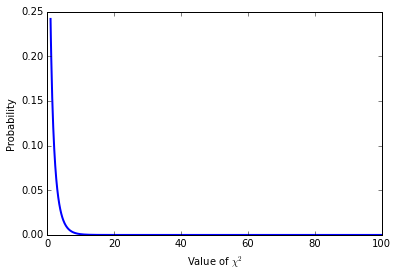

In [31]:
X = np.arange(1, 100, 0.1)
plt.plot(X, distribution.pdf(X), lw=2)
plt.ylabel('Probability')
plt.xlabel('Value of $\chi^2$')
plt.show()

We can calculate the probability of our observed log-likelihood from the PDF. If it is less than 0.05, then we can reject the null hypothesis.

In [33]:
distribution.pdf(loglikelihood), distribution.pdf(loglikelihood) < 0.05 

(3.6440419922948474e-16, True)

Money.

## A Bayesian approach

We have shown that these two corpora differ significantly in their usage of the term "photosynthesis". In many cases, we may want to go one step further, and actually quantify that difference. We can use a similar approach to the one that we used when comparing word use between years: use an MCMC simulation to infer mean rates of use (and credibility intervals) for each corpus. 

Rather than starting with a null hypothesis that there is no difference between corpora, we will begin with the belief that there is an independent rate of use for each corpus. We will then infer those rates, and sample from their posterior distributions to generate credible intervals.

Once again, we will model the rate of use with the Poisson distribution. So we must generate count data for evenly-sized chunks of each corpus. We'll put all of our count observations into a single dataframe.

In [70]:
count_data = pd.DataFrame(columns=['Journal', 'Year', 'Count'])
chunk_size = 400    # This shouldn't be too large.
i = 0

In [71]:
# The slice() function automagically divides each corpus up into
#  sequential years. We can use chain() to combine the two iterators
#  so that we only have to write this code once.
for year, papers in chain(pj_corpus.slice(), pp_corpus.slice()):
    tokens = [normalize_token(token) 
              for paper in papers    # getattr() lets us set a default.
              for token in nltk.word_tokenize(getattr(paper, 'abstract', '')) 
              if filter_token(token)]

    N = len(tokens)    # Number of tokens in this year.
    for x in xrange(0, N, chunk_size):
        current_chunk = tokens[x:x+chunk_size]    
        count = nltk.FreqDist(current_chunk)['photosynthesis']

        # Store the count for this chunk as an observation.
        count_data.loc[i] = [paper.journal, year, count]
        i += 1    # Increment the index variable.

In [75]:
PJ_mean = pymc.Gamma('PJ_mean', beta=1.)
PP_mean = pymc.Gamma('PP_mean', beta=1.)

PJ_counts = pymc.Poisson('PJ_counts', 
                         mu=PJ_mean, 
                         value=count_data[count_data.Journal == 'PLANT JOURNAL'].Count, 
                         observed=True)

PP_counts = pymc.Poisson('PP_counts', 
                         mu=PP_mean, 
                         value=count_data[count_data.Journal == 'PLANT PHYSIOLOGY'].Count, 
                         observed=True)

model = pymc.Model({
    'PJ_mean': PJ_mean,
    'PP_mean': PP_mean,
    'PJ_counts': PJ_counts,
    'PP_counts': PP_counts
})


In [76]:
M1 = pymc.MCMC(model)
M2 = pymc.MCMC(model)
M3 = pymc.MCMC(model)

In [77]:
M1.sample(iter=20000, burn=2000, thin=20)
M2.sample(iter=20000, burn=2000, thin=20)
M3.sample(iter=20000, burn=2000, thin=20)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.6 sec

Plotting PP_mean
Plotting PJ_mean


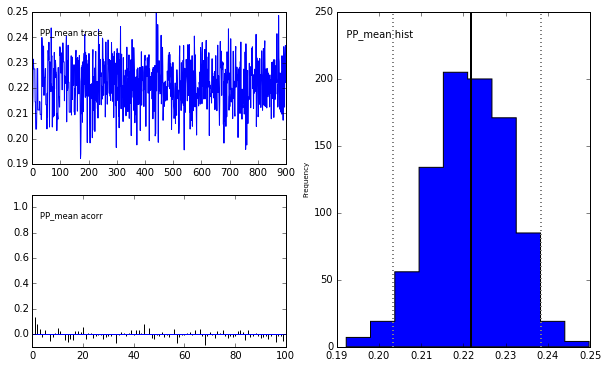

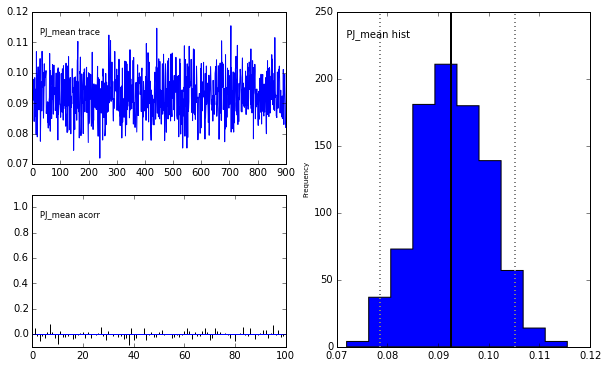

In [78]:
pymc.Matplot.plot(M1)

In [79]:
PJ_mean_samples = M1.PJ_mean.trace()[:]
PJ_mean_samples = np.append(PJ_mean_samples, M2.PJ_mean.trace()[:])
PJ_mean_samples = np.append(PJ_mean_samples, M3.PJ_mean.trace()[:])
PP_mean_samples = M1.PP_mean.trace()[:]
PP_mean_samples = np.append(PP_mean_samples, M2.PP_mean.trace()[:])
PP_mean_samples = np.append(PP_mean_samples, M3.PP_mean.trace()[:])

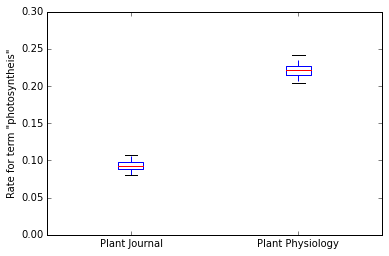

In [80]:
# Plot the 95% credible interval as box/whiskers.
plt.boxplot([PJ_mean_samples, PP_mean_samples],
            whis=[2.5, 97.5],
            labels=['Plant Journal', 'Plant Physiology'],
            showfliers=False)
plt.ylim(0, 0.3)
plt.ylabel('Rate for term "photosyntheis"')
plt.show()

# Feature selection

In [277]:
from sklearn.feature_extraction.text import CountVectorizer

In [278]:
vectorizer = CountVectorizer(input='content')

In [ ]:
vectorizer.fit_transform()

In [276]:
word_counts_df = pd.DataFrame(columns=['Year', 'Journal', 'Word', 'Count'])
for 

<ConditionalFreqDist with 3 conditions>